In [1]:
from matplotlib import pyplot as plt
from numcodecs import Blosc
import os
import imageio
import numpy as np
from anscombe_numcodecs import codec, estimate, AnscombeCodec
import zarr

### Load example data and estimate `zero_level` and `photon_sensitivity` 

In [2]:
data = np.load('../tests/data/data1.npz')['data']

In [3]:
# for bright images use count_weight_gamma=1
# for photon-starved images with few cells use count_weight_gamma = 0.001
# Otherwise, use the default

qs = estimate.compute_sensitivity(data, count_weight_gamma=1.0)
qs

{'model': HuberRegressor(),
 'counts': array([605, 679, 675, ...,  27,  20,  26]),
 'min_intensity': np.int64(90),
 'max_intensity': np.int64(3016),
 'variance': array([  5706.29669421,   5897.68851252,   5368.22962963, ...,
        250302.94444444, 566103.325     , 584751.57692308]),
 'sensitivity': np.float64(96.99485239898486),
 'zero_level': np.float64(86.30213581131535)}

The slope and x-intercept for the photon transfer curve yield the photon sensitivity and the zero level.

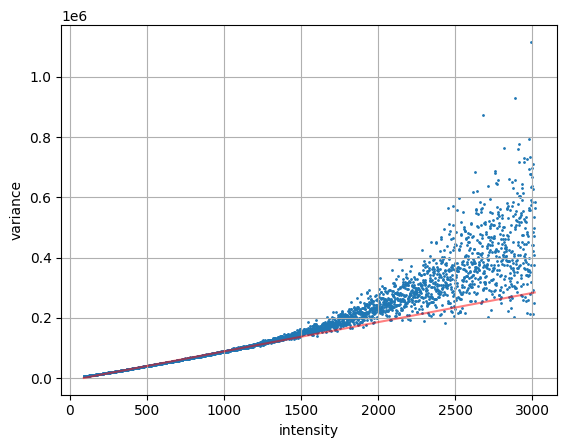

In [4]:
intensity = np.r_[qs['min_intensity']:qs['max_intensity']]
sensitivity = qs['sensitivity']
zero_level = qs['zero_level']
plt.scatter(intensity, qs['variance'], s=1)
plt.plot(intensity, (intensity - zero_level) * sensitivity, 'r', alpha=0.5)
plt.grid(True)
plt.xlabel('intensity')
plt.ylabel('variance');

## Illustrate with GIF compression
This does not use `zarr` and `numcodecs`

In [5]:
# make compression lookup tables
LUT1 = codec.make_anscombe_lookup(sensitivity, zero_level=zero_level)
LUT2 = codec.make_inverse_lookup(LUT1)

Text(0.5, 1.0, 'compression/decompression transform')

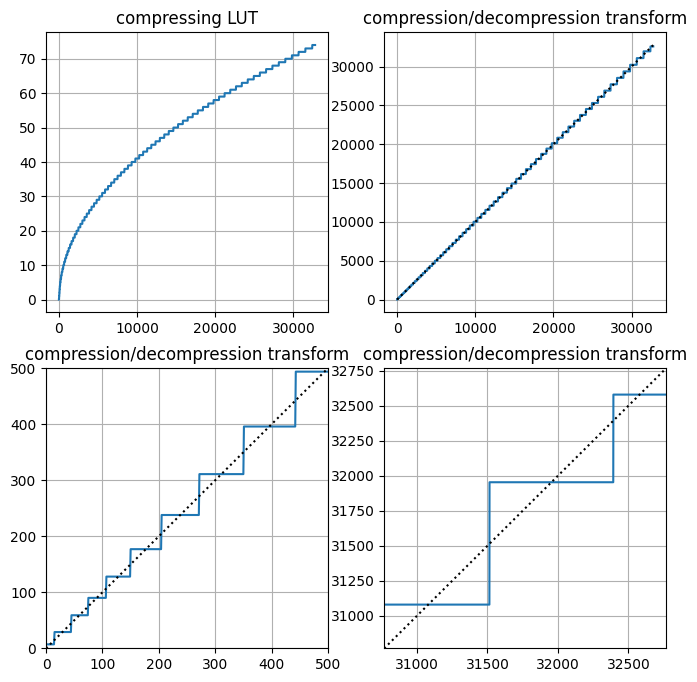

In [6]:
fig, axx = plt.subplots(2, 2, figsize=(8, 8))
axx = iter(axx.flatten())

ax = next(axx)
ax.plot(LUT1)
ax.grid(True)
ax.set_title('compressing LUT')

ax = next(axx)
ax.plot(LUT2[LUT1])
ax.plot(np.r_[:LUT1.size], np.r_[:LUT1.size], 'k:')
ax.grid(True)
ax.set_title('compression/decompression transform')

ax = next(axx)
ax.plot(LUT2[LUT1])
ax.plot(np.r_[:LUT1.size], np.r_[:LUT1.size], 'k:')
ax.grid(True)
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)
ax.set_title('compression/decompression transform')

ax = next(axx)
ax.plot(LUT2[LUT1])
ax.plot(np.r_[:LUT1.size], np.r_[:LUT1.size], 'k:')
ax.grid(True)
ax.set_xlim(LUT1.size-2000, LUT1.size)
ax.set_ylim(LUT1.size-2000, LUT1.size)
ax.set_title('compression/decompression transform')


In [7]:
(LUT2[LUT1[LUT2[LUT1]]] == LUT2[LUT1]).all()

np.True_

In [8]:
# save compressed video as .gif
compressed = codec.lookup(data, LUT1)
scale = 255//np.max(compressed)  # this makes the gif brighter. Use scale=1 normall
gif_path = 'test.gif'
with imageio.get_writer(gif_path, mode='I', duration=.01, loop=False) as f:
    for frame in compressed:
        f.append_data(scale * frame)
print(f'Compression ratio: {np.prod(data.shape)*2 / os.path.getsize(gif_path):0.2f}')

Compression ratio: 3.57


You may open and view the saved `test.gif`

### Illustrate image compression using numcodecs / zarr

In [9]:
# instantiate Anscombe object
poisson_filter = AnscombeCodec(zero_level, sensitivity)

In [10]:
z = zarr.open('test.zarr', shape=data.shape, 
              dtype=data.dtype, filters=[poisson_filter], 
              compressor=Blosc(cname='zstd', clevel=1))
z[...] = data

In [11]:
z.info

Type,zarr.core.Array
Data type,int16
Shape,"(300, 200, 200)"
Chunk shape,"(75, 50, 100)"
Order,C
Read-only,False
Filter [0],"AnscombeCodec(decoded_dtype='int16', encoded_dtype='int8', photon_sensitivity=96.99485239898486, zero_level=86.30213581131535)"
Compressor,"Blosc(cname='zstd', clevel=1, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,24000000 (22.9M)
No. bytes stored,5384805 (5.1M)


# RESTART THE KERNEL
Restart the kernel manually to test zarr loading from scratch in the following cells

In [12]:
import matplotlib.pyplot as plt
import zarr
from anscombe_numcodecs import AnscombeCodec

# you don't need to import poisson_numcodecs but it must be installed

In [13]:
# open zarr
reopened = zarr.open('test.zarr', mode='r')
reopened.info

Type,zarr.core.Array
Data type,int16
Shape,"(300, 200, 200)"
Chunk shape,"(75, 50, 100)"
Order,C
Read-only,True
Filter [0],"AnscombeCodec(decoded_dtype='int16', encoded_dtype='int8', photon_sensitivity=96.99485239898486, zero_level=86.30213581131535)"
Compressor,"Blosc(cname='zstd', clevel=1, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,24000000 (22.9M)
No. bytes stored,5384805 (5.1M)


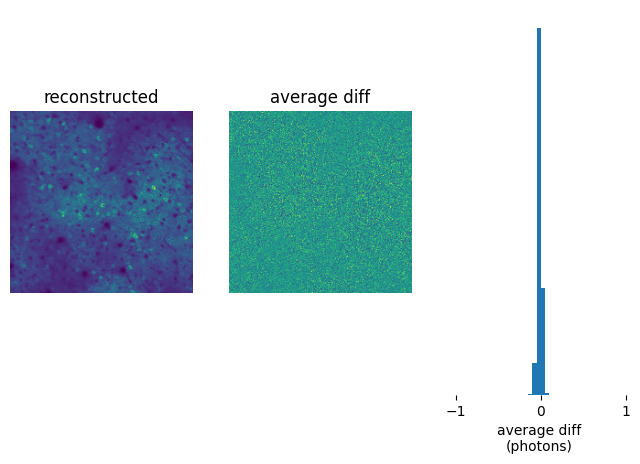

In [14]:
# error analysis
fig, axx = plt.subplots(1, 3, figsize=(8, 5))
data = np.load('../tests/data/data1.npz')['data']
recon = reopened[:]
err = data - recon
axx[0].imshow(recon.mean(axis=0))
axx[0].set_title('reconstructed')
axx[0].axis(False)
axx[1].imshow(err.mean(axis=0))
axx[1].set_title('average diff')
axx[1].axis(False)
axx[2].hist(err.mean(axis=0).flatten() / sensitivity,np.r_[-1:1:0.05])
axx[2].set_xlabel('average diff\n(photons)')
axx[2].get_yaxis().set_ticks([])
for s in axx[2].spines.values():
    s.set_visible(False)